In [1]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [2]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
X_train = batch_1['data']
X_train.shape

(10000, 3072)

In [4]:
Y_train = batch_1['labels']
len(Y_train)

10000

#### data
A 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
#### labels
A list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

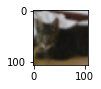

In [5]:
import matplotlib.pyplot as plt
import scipy
import scipy.misc
%matplotlib inline
import numpy as np
%matplotlib inline
plt.figure(figsize =(1,1))
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (106,106)) 
plt.imshow(image)

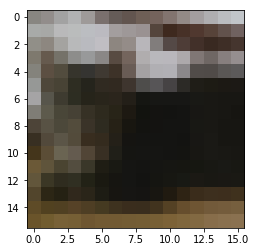

In [6]:
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (16,16)) 
plt.imshow(image)

In [7]:
def leaky_relu(X, alpha=0.3):
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [21]:
import tensorflow as tf
tf.reset_default_graph()

def from_rgb(X):
    w_1 = tf.get_variable('from_rgb_w1', [1, 1, 3, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_1 = tf.get_variable("from_rgb_b1", [16], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_1a = tf.nn.conv2d(X, w_1, [1,1,1,1], padding='SAME') + b_1;
    l_1b = leaky_relu(l_1a)
    
    w_2 = tf.get_variable('from_rgb_w2', [3, 3, 16, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_2 = tf.get_variable("from_rgb_b2", [16], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_2a = tf.nn.conv2d(l_1b, w_2, [1,1,1,1], padding='SAME') + b_2;
    l_2b = leaky_relu(l_2a)

    w_3 = tf.get_variable('from_rgb_w3', [3, 3, 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
    b_3 = tf.get_variable("from_rgb_b3", [32], initializer = tf.truncated_normal_initializer(stddev=0.02))    
    l_3a = tf.nn.conv2d(l_2b, w_3, [1,1,1,1], padding='SAME') + b_3;
    l_3b = leaky_relu(l_3a)

    return tf.nn.avg_pool(l_3b, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')

def discriminator(X, epoch, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        block = from_rgb(X)
        
        # TODO: Grow
        
        num_channels = 32 #TODO

        w_1 = tf.get_variable('final_w1', [3, 3, num_channels, num_channels], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_1 = tf.get_variable("final_b1", [num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        final_1a = tf.nn.conv2d(block, w_1, [1,1,1,1], padding='SAME') + b_1
        final_1b = leaky_relu(final_1a)

        w_2 = tf.get_variable('final_w2', [4, 4, num_channels, num_channels], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_2 = tf.get_variable("final_b2", [num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        final_2a = tf.nn.conv2d(final_1b, w_2, [1,1,1,1], padding='VALID') + b_2
        final_2b = leaky_relu(final_2a)
        return tf.layers.dense(final_2b, 1, activation=None)
        
        

In [22]:
def generator(z, zdim, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        return;

In [23]:
X = tf.placeholder(tf.float32, [None, 64, 64, 3])
Dx = discriminator(X, 0)
# Gz = generator(z_placeholder, 100, 100, False)
# Dg = discriminator(Gz, True)


In [24]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))

In [25]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D/' in var.name]

In [26]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)


In [27]:
batch_size = 32
num_epochs = 200
verbose = True
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        batch = np.resize(X_train[epoch*batch_size:(epoch+1)*batch_size], (batch_size, 64, 64, 3))
        _, cost = session.run([optimizer_d_real, d_cost_real], feed_dict={X: batch})
        if verbose and epoch % 20 == 0:
            print cost

0.676355
2.05968e-24


KeyboardInterrupt: 